# Flying Mantines

ModSim Project 3

Lydia Hodges and Chase Joyner

License: [Creative Commons Attribution 4.0 International](https://creativecommons.org/licenses/by/4.0)

In [1]:
%matplotlib inline

from modsim import *

In [2]:
m = UNITS.meter
s = UNITS.second
kg = UNITS.kilogram
degree = UNITS.degree
radian = UNITS.radian

In [3]:
angle = 90 * degree

condition_m = Condition(x = 0 * m, 
                      y = 0 * m,
                      g = 9.8 * m/s**2,
                      diameter = 0.75 * m,   #6.7 * m,
                      mass = 214 * kg,   #1350 * kg,
                      rho = 1.2 * kg/m**3,
                      angle = angle,
                      den = 1000 * kg/m**3,
                      C_d = 1.28 * np.sin(np.deg2rad(angle)),
                      C_l = 2 * np.pi * np.deg2rad(angle),
                      wing_area = 1.18 * m**2,   #14.14 * m**2,
                      velocity = 13.4 * m / s,   #9.83 * m / s,
                      bh = 4.9 * m,
                      duration = 1 * s)
angle_array = linrange(45, 90, 1)

In [4]:
def make_system(condition):
    
    unpack(condition)
    
    # convert angle to degrees
    theta = np.deg2rad(angle)
    
    # compute x and y components of velocity
    vx, vy = pol2cart(theta, velocity)
    
    # make the initial state
    init = State(x=x, y=y, vx=vx, vy=vy)
    
    # compute area from diameter
    area = np.pi * (diameter/2)**2
    
    # compute timestamps
    ts = linspace(0, duration, 101)
    
    return System(init=init, g=g, mass=mass, 
                  area=area, rho=rho, C_d=C_d, ts=ts)

In [5]:
system = make_system(condition_m)

In [6]:
def slope_func_m(state, t, system):
    
    x, y, vx, vy = state
    unpack(system)
    
    a_grav = Vector(0, -g)

    v = Vector(vx, vy)
    
    f_drag = -C_d * wing_area * rho * (v**2 / 2)
    a_drag = f_drag / mass
    
    f_lift = C_l * wing_area * rho * (v**2 / 2)
    a_lift = f_lift / mass
    
    a = a_grav + a_drag + a_lift
    
    #print(mass, C_l, a_lift, C_d, a_drag)
    
    return vx, vy, a.x, a.y

In [7]:
slope_func_m(system.init, 0, system)

(<Quantity(8.205133554287267e-16, 'meter / second')>,
 <Quantity(13.4, 'meter / second')>,
 <Quantity(1.9132157869553186e-32, 'meter / second ** 2')>,
 <Quantity(-4.6972740592906534, 'meter / second ** 2')>)

In [8]:
run_odeint(system, slope_func_m)
print(system.results)

                 x          y            vx         vy
0.00  0.000000e+00   0.000000  8.205134e-16  13.400000
0.01  8.205134e-18   0.133765  8.205134e-16  13.352848
0.02  1.641027e-17   0.267056  8.205134e-16  13.305337
0.03  2.461540e-17   0.399870  8.205134e-16  13.257465
0.04  3.282053e-17   0.532204  8.205134e-16  13.209232
0.05  4.102567e-17   0.664053  8.205134e-16  13.160634
0.06  4.923080e-17   0.795415  8.205134e-16  13.111672
0.07  5.743593e-17   0.926286  8.205134e-16  13.062344
0.08  6.564107e-17   1.056661  8.205134e-16  13.012648
0.09  7.384620e-17   1.186537  8.205134e-16  12.962583
0.10  8.205134e-17   1.315911  8.205134e-16  12.912148
0.11  9.025647e-17   1.444779  8.205134e-16  12.861341
0.12  9.846160e-17   1.573137  8.205134e-16  12.810162
0.13  1.066667e-16   1.700981  8.205134e-16  12.758609
0.14  1.148719e-16   1.828308  8.205134e-16  12.706680
0.15  1.230770e-16   1.955114  8.205134e-16  12.654376
0.16  1.312821e-16   2.081394  8.205134e-16  12.601693
0.17  1.39

Saving figure to file Proj3_SingleRun.eps


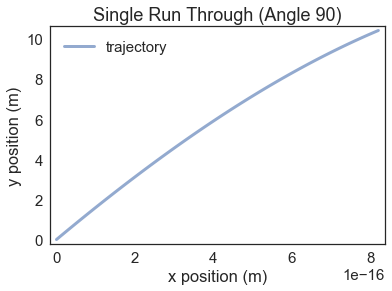

In [9]:
xs = system.results.x
ys = system.results.y
newfig()
plot(xs, ys, label='trajectory')
decorate(xlabel='x position (m)',
         ylabel='y position (m)',
        title='Single Run Through (Angle 90)')
savefig('Proj3_SingleRun.eps', bbox_inches='tight')

In [10]:
def sweep_param(angle_array, system):
    newfig()
    plot((0, 11), (4.9, 4.9), 'k', label='face of individual')
    decorate(xlabel='x position (m)',
             ylabel='y position (m)',
             title='Sweep Angle (45 - 90)')
    for ang in angle_array:
        condition_m.set(angle=ang)
        system = make_system(condition_m)
        run_odeint(system, slope_func_m)
        xs = system.results.x
        ys = system.results.y
        plot(xs, ys)
    savefig('Proj3_SweepAngle.eps', bbox_inches='tight')

Saving figure to file Proj3_SweepAngle.eps


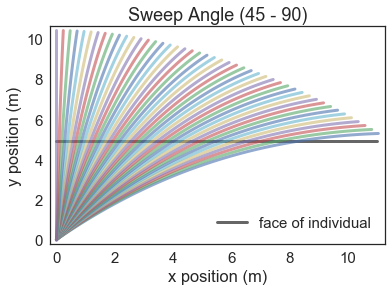

In [11]:
sweep_param(angle_array, system)

In [12]:
def run_sim(state, system, angle_array):
    
    f_table = []
    
    for ang in angle_array:
        condition_m.set(angle=ang)
        system = make_system(condition_m)
        run_odeint(system, slope_func_m)
        h = system.results.y.loc(4.9)
        f = slope_func_m(system.init, h, system)
        acc = sqrt((f[2])**2 + (f[3])**2)
        force = mass * acc
        meh = force / (kg * m / s**2)
        f_table.append(meh)
    return f_table
        #print('angle =', angle, 'force =', force)

In [13]:
sim = run_sim(system.init, system, angle_array)
total = []
for elem in sim:
    hmm = elem + 781.9
    total.append(hmm)

In [14]:
almost_done = Series(sim, angle_array)
maybe_done = Series(total, angle_array)
#print(almost_done)
print(maybe_done)

45.0    2426.3920721608747 dimensionless
46.0     2402.133548057337 dimensionless
47.0     2377.990695652938 dimensionless
48.0     2353.996406254952 dimensionless
49.0     2330.183233580413 dimensionless
50.0     2306.583321394425 dimensionless
51.0     2283.228329392907 dimensionless
52.0     2260.149357531202 dimensionless
53.0      2237.37686906293 dimensionless
54.0    2214.9406126246295 dimensionless
55.0    2192.8695437806327 dimensionless
56.0    2171.1917465285414 dimensionless
57.0    2149.9343553574085 dimensionless
58.0    2129.1234785463735 dimensionless
59.0     2108.784123488766 dimensionless
60.0    2088.9401249224074 dimensionless
61.0    2069.6140770374222 dimensionless
62.0    2050.8272705139457 dimensionless
63.0    2032.5996356089345 dimensionless
64.0     2014.949692458657 dimensionless
65.0     1997.894509786045 dimensionless
66.0     1981.449673194696 dimensionless
67.0     1965.629264189145 dimensionless
68.0    1950.4458509799624 dimensionless
69.0    1935.910

Saving figure to file ForceVsAngle.eps


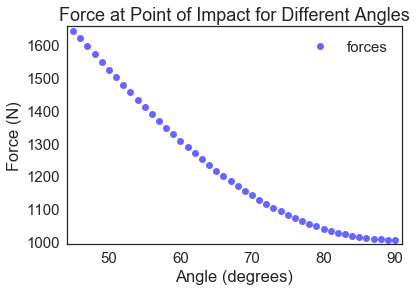

In [15]:
#print(almost_done)
newfig()
plot(almost_done, 'bo', label='forces')
decorate(xlabel='Angle (degrees)',
         ylabel='Force (N)',
         title='Force at Point of Impact for Different Angles')
savefig('ForceVsAngle.eps', bbox_inches='tight')

Saving figure to file TotalForceApplied.eps


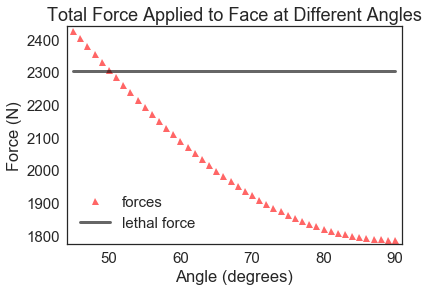

In [16]:
newfig()
plot(maybe_done, 'r^', label='forces')
plot((45, 90), (2304, 2304), 'k', label='lethal force')
decorate(xlabel='Angle (degrees)',
         ylabel='Force (N)',
         title='Total Force Applied to Face at Different Angles')
savefig('TotalForceApplied.eps', bbox_inches='tight')